In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
print(pc.__version__)

0.9.10b1


In [2]:
# Tell pyCloudy where the executable is to be found
pc.config.cloudy_exe = 'cloudy.exe'

In [3]:
# Define the directory where the models will be run
import os
dir_ = os.environ['HOME'] + '/SIGNALS_models'
pc.print_make_file(dir_)

## The following function write N files corresponding to different angles of an elliptical HII region

In [4]:
from pyCloudy.utils.physics import abund_Nicholls_GC_2017

def set_models(model_name, Teff, QH, a, dist, N_models):
    """
    model_name: generic name for the models
    Teff: effective temperature of the central BB
    QH: number of ionizing photons of the central BB
    a: ellipsicity
    dist: distance (kpc)
    N_models: number of models
    """
    emis_tab = ['H  1 4861.33A', 
                'H  1 6562.81A', 
                'N  2 6583.45A', 
                'O  2 3726.03A',
                'O  2 3728.81A',                          
                'O  3 5006.84A',
                'BLND 4363.00A',
                'S  2 6730.82A',
                'S  2 6716.44A']  
    thetas = np.linspace(0., 90., N_models)
    thetas_rad = np.pi / 180. * thetas
    # The fact_elli is used for the inner radius (increasing) and density (decreasing)
    fact_elli = a / np.sqrt((np.sin(thetas_rad))**2 + (a * np.cos(thetas_rad))**2)
    rs_in = 18.5 + np.log10(fact_elli)
    densities = 2 - np.log10(fact_elli) * 0
    
    model = pc.CloudyInput()
    model.set_BB(Teff, 'q(H)', QH)
    model.set_abund(ab_dict=abund_Nicholls_GC_2017)
    model.set_grains('ism')
    model.set_emis_tab(emis_tab)
    model.set_distance(dist=dist, unit='kpc', linear=True)
    
    for theta, r_in, density in zip(thetas, rs_in, densities):
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name,theta)
        model.set_cste_density(density)
        model.set_radius(r_in)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)

In [5]:
model_name = "M3D_1"
pc.log_.level = 3

In [6]:
Teff = 40000
QH = 49.
a = 3.
dist = 50
N_models = 6
set_models(model_name, Teff, QH, a, dist, N_models)

     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_0.in
     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_18.in
     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_36.in
     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_54.in
     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_72.in
     CloudyInput: Input writen in /Users/christophemorisset/SIGNALS_models/M3D_1_90.in


In [ ]:
pc.run_cloudy(dir_ = dir_, n_proc = 6, model_name = model_name, use_make = True)

In [22]:
pc.log_.level = 3
list_of_models = pc.load_models('{0}/{1}'.format(dir_, model_name), 
                                 list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
                                 read_cont = False, read_grains = False)

     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: Creating CloudyModel for /Users/christophemorisset/SIGNALS_models/M3D_1_18
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: Be abundance not defined
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: /Users/christophemorisset/SIGNALS_models/M3D_1_18.rad read
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: Number of zones: 105
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: /Users/christophemorisset/SIGNALS_models/M3D_1_18.phy read
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: /Users/christophemorisset/SIGNALS_models/M3D_1_18.ele_H read
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: filling H with 3 columns
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: /Users/christophemorisset/SIGNALS_models/M3D_1_18.ele_He read
     CloudyModel /Users/christophemorisset/SIGNALS_models/M3D_1_18: f

## Define a 3D object that build a cube by interpolating between the N models. Only 1/8th of the nebula have been modeled, the remaining part is obtained by mirroring.

In [11]:
dim = 101
m3d = pc.C3D(list_of_models, dims = [dim, dim, dim], angles = [45,45,0], plan_sym = True)

## Define a function to plot some results

In [12]:
def some_plots(m3d, proj_axis, n_cut):
    f, axes = plt.subplots(3,3, figsize=(15, 14))
    
    i_ax = 0
    ax = axes.ravel()[i_ax]
    im = ax.imshow(m3d.get_emis('H__1_486133A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    ax.set_title('Hb')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    im = ax.imshow(m3d.get_emis('N__2_658345A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    ax.set_title('[NII]')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    im = ax.imshow(m3d.get_emis('O__3_500684A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    ax.set_title('[OIII]')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    im = ax.imshow(m3d.get_emis('N__2_658345A').sum(axis = proj_axis)/
               m3d.get_emis('H__1_486133A').sum(axis = proj_axis))
    ax.set_title('[NII]/Hb')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    ax.imshow(m3d.get_emis('O__3_500684A').sum(axis = proj_axis)/
               m3d.get_emis('H__1_486133A').sum(axis = proj_axis))
    ax.set_title('[OIII]/Hb')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    im = ax.imshow(m3d.get_ionic('O',1)[:,:,n_cut])
    ax.set_title('O+ cut')
    f.colorbar(im, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    sc = ax.scatter(m3d.get_ionic('O',1).ravel(),
                np.log10(m3d.get_ionic('N',1).ravel()/
                         m3d.get_ionic('O',1).ravel()),
                c=np.abs(m3d.cub_coord.theta.ravel()), edgecolors = 'none')
    ax.set_title('Colored by |Theta|')
    ax.set_xlabel('O+ / O')
    ax.set_ylabel('log N+/O+ / N/O')
    f.colorbar(sc, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    sc = ax.scatter(m3d.get_ionic('O',1).ravel(),
                np.log10(m3d.get_ionic('N',1).ravel()/
                         m3d.get_ionic('O',1).ravel()),
                c=m3d.relative_depth.ravel(),vmin = 0, vmax = 1, edgecolors = 'none')
    ax.set_title('Colored by radial angular position in the nebula')
    ax.set_xlabel('O+ / O')
    ax.set_ylabel('N+/O+ / N/O')
    f.colorbar(sc, ax=ax)
    
    i_ax += 1
    ax = axes.ravel()[i_ax]
    im = m3d.get_RGB(['N__2_658345A', 'H__1_486133A', 'O__3_500684A'], axes = proj_axis)
    ax.imshow(im)

## Each time the rotation angles are changed, a new interpolator is set up and the emission lines need to be recomputed.

     CubCoord: building a cube of 101x101x101
     CubCoord: Rotation matrix by 45.0, 0.0, 0.0 degrees.
     C3D: CubCoord done.
     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset
     C3D: get_emis(0) interpolated using numpy-method
     C3D: get_emis(2) interpolated using numpy-method
     C3D: get_emis(5) interpolated using numpy-method
     C3D: get_ionic('O', 1) interpolated using numpy-method


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


     C3D: get_ionic('N', 1) interpolated using numpy-method


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


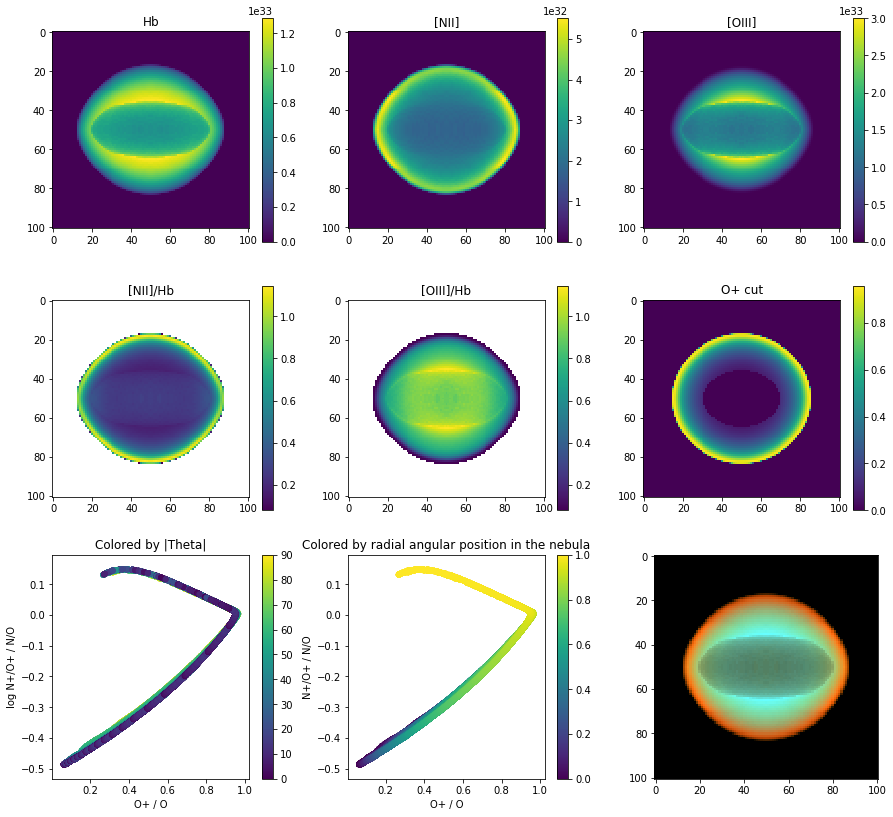

In [35]:
m3d.angles = [45,0,0]
proj_axis = 1
some_plots(m3d, proj_axis, n_cut = int((dim-1) /2))

## Analysing the effect of an aperture on the line ratios

In [36]:
# A function in form of lambda to transform size in cm into arcsec, for a distance "dist" defined above.
from pyCloudy.utils.astro import conv_arc
arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)

In [37]:
def make_mask(m3d, ap_center=[0., 0.], ap_size=[1., 1.]):
    """
    This returns a mask (values between 0. and 1.) to be multiplied to the image to take into account the flux passing through an aperture.
    """
    x_arc = arcsec(m3d.cub_coord.x_vec)
    y_arc = arcsec(m3d.cub_coord.y_vec)
    z_arc = arcsec(m3d.cub_coord.z_vec)
    X, Y = np.meshgrid(y_arc, x_arc)
    bool_mask = ((X > ap_center[0] - ap_size[0]/2.) & 
            (X <= ap_center[0] + ap_size[0]/2.) & 
            (Y > ap_center[1] - ap_size[1]/2.) & 
            (Y <= ap_center[1] + ap_size[1]/2.))
    mask = np.zeros_like(X)
    mask[bool_mask] = 1.0
    return mask

## The mask can be change to see the effect of the aperture on line intensities

In [47]:
mask = make_mask(m3d, ap_center=[0.0, 4.0], ap_size=[5, 1.5])

## The [OIII] image is shown and the mask is overploted.

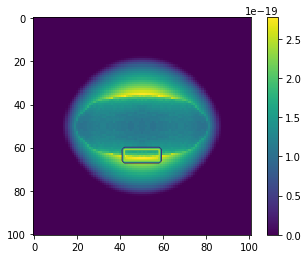

In [48]:
f, ax = plt.subplots()
im = ax.imshow(m3d.get_emis('O__3_500684A').sum(axis=proj_axis))
f.colorbar(im, ax=ax)
ax.contour(mask);

## Hbeta is computed for the whole object and throught the aperture

In [49]:
Hb_tot = (m3d.get_emis('H__1_486133A') * m3d.cub_coord.cell_size).sum()
Hb_slit = ((m3d.get_emis('H__1_486133A') * m3d.cub_coord.cell_size).sum(proj_axis) * mask).sum()
print(Hb_tot, Hb_slit)

3.065072583249524e+36 1.0979935822169868e+35


## For every line, we compute the intensity for the whole object and throught the aperture. We also print out the difference due to the slit.

In [50]:
for label in m3d.m[0].emis_labels:
    I_tot = (m3d.get_emis(label).sum()*m3d.cub_coord.cell_size) / Hb_tot
    I_slit = ((m3d.get_emis(label).sum(proj_axis) * mask).sum()*m3d.cub_coord.cell_size) / Hb_slit
    print('line: {0:12s} I/Ib Total: {1:6.4f} I/Ib Slit: {2:6.4f} Delta: {3:4.1f}%'.format(label, I_tot, I_slit, 
                                                                                           (I_slit-I_tot)/I_tot*100))

line: H__1_486133A I/Ib Total: 1.0000 I/Ib Slit: 1.0000 Delta: -0.0%
line: H__1_656281A I/Ib Total: 2.8260 I/Ib Slit: 2.8205 Delta: -0.2%
line: N__2_658345A I/Ib Total: 0.3706 I/Ib Slit: 0.2006 Delta: -45.9%
line: O__2_372603A I/Ib Total: 0.5903 I/Ib Slit: 0.3533 Delta: -40.1%
line: O__2_372881A I/Ib Total: 0.7902 I/Ib Slit: 0.4723 Delta: -40.2%
line: O__3_500684A I/Ib Total: 1.5664 I/Ib Slit: 2.1558 Delta: 37.6%
line: BLND_436300A I/Ib Total: 0.0021 I/Ib Slit: 0.0029 Delta: 36.7%
line: S__2_673082A I/Ib Total: 0.1209 I/Ib Slit: 0.0657 Delta: -45.7%
line: S__2_671644A I/Ib Total: 0.1562 I/Ib Slit: 0.0847 Delta: -45.8%


In [44]:
[M.log_U_mean for M in list_of_models]

[-2.0585355101459712,
 -2.107891566632956,
 -2.6003719960373495,
 -2.044398646021122,
 -2.2123477474576263,
 -2.4147865037198333]

## Let's have a look at the position in the BPT diagram of the observed spaxels (Veronica Gomez-Llanos's project in SIGNALS).

In [51]:
im_O3 = m3d.get_emis('O__3_500684A').sum(axis=proj_axis) 
im_Hb = m3d.get_emis('H__1_486133A').sum(axis=proj_axis)
im_N2 = m3d.get_emis('N__2_658345A').sum(axis=proj_axis) 
im_Ha = m3d.get_emis('H__1_656281A').sum(axis=proj_axis)
mask = (im_O3 > np.max(im_O3)/10) &  (im_Hb > np.max(im_Hb)/10) &  (im_N2 > np.max(im_N2)/10) &  (im_Ha > np.max(im_Ha)/10)

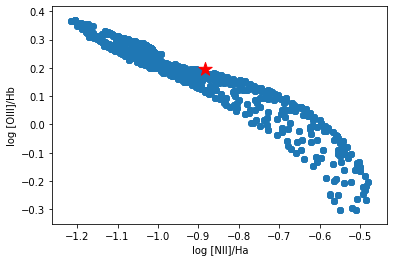

In [52]:
f, ax = plt.subplots()
ax.scatter(np.log10(im_N2/im_Ha)[mask], np.log10(im_O3/im_Hb)[mask])
ax.scatter(np.log10(im_N2.sum()/im_Ha.sum()), np.log10(im_O3.sum()/im_Hb.sum()), c='r', marker='*', s=200)
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb');

## Each spaxel could be used to compute abundances, from O3N2 or N2 for example. THIS IS A BIG MISTAKE!!!

## In this example, [NII]/Ha is spreading over almost one order of magnitude. But O/H and N/H is CONSTANT within the region... What we see here is the effect of logU changing in the nebula, NOT the metallicity.

## Have a look at https://ui.adsabs.harvard.edu/abs/2018wtl..confE...2M